This file downloads NOAA's StormEvents data from 1950 to 2024 and selects from the obtained dataframe the entries corresponding to relevant tornadoes.

### Importing Tornado Data

In [1]:
import pandas as pd
import requests
from io import BytesIO

base_url = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/"
creation_date = "20250520"  
all_years_data = []


for year in range(1950, 2025):
    print(f"\nProcessing year: {year}")

    if year == 1950:
        date = 20250401
    elif year == 2020:
        date = 20240620
    else:
        date = creation_date
    details_file = f"StormEvents_details-ftp_v1.0_d{year}_c{date}.csv.gz"


    def download_csv_gz(file_name):
        url = base_url + file_name
        try:
            r = requests.get(url)
            r.raise_for_status()
            return pd.read_csv(BytesIO(r.content), compression='gzip', low_memory=False)
        except Exception as e:
            print(f"Failed to load {file_name}: {e}")
            return None

    df_details = download_csv_gz(details_file)

    if df_details is None:
        continue

    df_details.columns = df_details.columns.str.lower()

    if 'event_id' not in df_details.columns:
        continue

    if year >= 1950 and year < 2007:
        f_list = ['F0', 'F1', 'F2', 'F3', 'F4', 'F5']
    else:
        f_list = ['EF0', 'EF1', 'EF2', 'EF3', 'EF4', 'EF5']
    df_tornadoes = df_details[
    (df_details['event_type'] == 'Tornado') &
    (df_details['tor_f_scale'].isin(f_list))].copy()

    df_tornadoes['year'] = year  


    if df_tornadoes.empty:
        continue

    
    df_tornadoes['year'] = year
    df_tornadoes['month'] = df_tornadoes['begin_yearmonth'] % 100
    all_years_data.append(df_tornadoes[['state', 'begin_lat', 'begin_lon', 'tor_f_scale', 'begin_day', 'month', 'year']])


combined_df = pd.concat(all_years_data, ignore_index=True)

def year_to_bin(y):
    base = y - (y % 4)
    return f"{base}-{base + 3}"

combined_df['year_bin'] = combined_df['year'].apply(year_to_bin)


#binned_summary = combined_df.groupby(['year_bin', 'state', 'begin_lat', 'begin
# _lon', 'tor_f_scale']) \
#                            .size().reset_index(name='count')


#binned_summary.to_csv("1952_2007.csv", index=False)




Processing year: 1950

Processing year: 1951

Processing year: 1952

Processing year: 1953

Processing year: 1954

Processing year: 1955

Processing year: 1956

Processing year: 1957

Processing year: 1958

Processing year: 1959

Processing year: 1960

Processing year: 1961

Processing year: 1962

Processing year: 1963

Processing year: 1964

Processing year: 1965

Processing year: 1966

Processing year: 1967

Processing year: 1968

Processing year: 1969

Processing year: 1970

Processing year: 1971

Processing year: 1972

Processing year: 1973

Processing year: 1974

Processing year: 1975

Processing year: 1976

Processing year: 1977

Processing year: 1978

Processing year: 1979

Processing year: 1980

Processing year: 1981

Processing year: 1982

Processing year: 1983

Processing year: 1984

Processing year: 1985

Processing year: 1986

Processing year: 1987

Processing year: 1988

Processing year: 1989

Processing year: 1990

Processing year: 1991

Processing year: 1992

Processing

Following the year 2007, the Fujita scale for measuring tornado strength was replaced with the Enhanced Fujita scale. This is reflected in the data with tornado strength described by 'EF2', for example, instead of 'F2'. Here we account for this change.

In [2]:
def normalize_scale(scale):
    if isinstance(scale, str) and scale.strip().upper().startswith(('EF', 'F')):
        return f"F{scale[-1]}"  
    return scale

combined_df['tor_f_scale'] = combined_df['tor_f_scale'].apply(normalize_scale)


## Importing Hurricane Data and Removing Corresponding Tornadoes

We need some information on hurricanes in order to eliminate from our tornado data any tornadoes which arise from a hurricane, via the phenomena of wind shear. The tornadoes we are interested in are tornadoes occuring independently of hurricanes. As such, we'll remove any tornadoes that appear within 200 miles of a hurricane within a few days of when the hurricane is present.

In [4]:
from io import StringIO

hurricane_link = 'https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2024-040425.txt'

r = requests.get(hurricane_link)
hurricane_df = pd.read_csv(StringIO(r.text))
hurricanes = str(r.text).split('AL')[1:]

j = 0
for i in range(len(hurricanes)):
    # We need to eliminate hurricanes with names containing 'AL'
    if hurricanes[i-j][0][0].isupper():
        hurricanes[i-j-1] += "AL" + hurricanes[i-j]
        del hurricanes[i-j]
        j += 1
    elif hurricanes[i-j][0][0] == ',':
        hurricanes[i-j-1] += "AL" + hurricanes[i-j]
        del hurricanes[i-j]
        j += 1

hurricane_trails = []
i = -1
for storm in hurricanes:
    i += 1
    year = storm[2:6]
    if (1950 <= int(year) <= 2024):
        recordings = storm.split(year)[2:]
    
        if recordings != []:
            month = recordings[0][0:2]
            day = recordings[0][2:4]

            path = []
            for entry in recordings:
                npos = entry.find('N,')
                while True:
                    if not entry[npos-1].isnumeric():
                        npos = entry[npos+1:].find('N,') + npos + 1
                    else:
                        break

                wpos = entry.find('W,')            
                while True:
                    if not entry[wpos-1].isnumeric():
                        wpos = entry[wpos+1:].find('W,') + wpos + 1
                    else:
                        break

                latitude = float(entry[npos-5:npos])
                longitude = -1 * float(entry[wpos-5:wpos])

                path.append((latitude,longitude))
    
            hurricane_trails.append((year, month, day, path))


In [5]:
from math import sin, cos, sqrt, atan2, radians

def dist_from_latlon(pt1, pt2):
    '''
        Computes the distance, in miles, between pt1 and pt2 on Earth's surface, where pt1 and pt2 are (latitude,longitude) pairs.
            Gives a valid formula for points in or near the US.
    '''
    R = 3963.1

    lat1 = radians(pt1[0])
    lon1 = radians(pt1[1])
    lat2 = radians(pt2[0])
    lon2 = radians(pt2[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

def get_dist_from_pts(row,pts):
    '''
        Given a row in the tornado dataframe, finds the minimum distance from that entry 
            to the list of given points (consisting of latitude,longitude pair)
    '''
    return min([dist_from_latlon((row['begin_lat'],row['begin_lon']),pt) for pt in pts])

In [6]:
import datetime

def remove_tornadoes_near_hurricane(tornado_df, hurricane_trail):
    '''
        Takes as input the dataframe of all tornadoes and a given hurricane trail of the form 
            (year,month,day,path)
            with path a list of (latitude,longitude) pairs

        Drops all entries from tornado_df which fall within 200 miles of the hurricane's path within two weeks of the storm's beginning.
    '''
    year, month, day, path = hurricane_trail
    date = datetime.datetime(int(year),int(month),int(day))
    for i in range(14):
        year = date.year
        month = date.month
        day = date.day

        tornadoes = tornado_df[tornado_df['year']==year]
        tornadoes = tornadoes[tornadoes['month']==month]
        tornadoes = tornadoes[tornadoes['begin_day']==day].copy()

        tornadoes['dist'] = tornadoes.apply(lambda x: get_dist_from_pts(x,path),axis=1)
        tornadoes = tornadoes[tornadoes['dist'] < 200]

        tornado_df = tornado_df.drop(tornadoes.index)

        date += datetime.timedelta(1)
    
    return tornado_df


In [7]:
for trail in hurricane_trails:
    combined_df = remove_tornadoes_near_hurricane(combined_df,trail)

### Saving the Tornado Data

In [8]:
combined_df = combined_df[['state', 'begin_lat', 'begin_lon', 'tor_f_scale', 'year']]

In [10]:
combined_df.to_csv('all_tornadoes.csv')

### Some Unnecessary Hurricane Visualization, If Desired

In [157]:
import matplotlib.pyplot as plt
import geopandas as gpd

In [172]:
states = gpd.read_file('cb_2024_us_state_5m.zip')
states_to_remove = ['VI', 'MP', 'AK','HI','PR','AS', 'GU']
states = states[~states['STUSPS'].isin(states_to_remove)]

<Figure size 5000x5000 with 0 Axes>

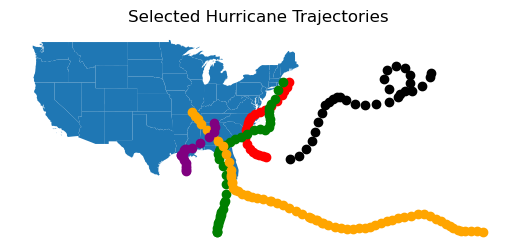

In [321]:
plt.figure(figsize = (50,50))
states.plot()

storm = 206
xs = [thing[1] for thing in hurricane_trails[storm][3]]
ys = [thing[0] for thing in hurricane_trails[storm][3]]
plt.scatter(xs,ys,c='red')

storm = 188
xs = [thing[1] for thing in hurricane_trails[storm][3]]
ys = [thing[0] for thing in hurricane_trails[storm][3]]
plt.scatter(xs,ys,c='green')

storm = 1033
xs = [thing[1] for thing in hurricane_trails[storm][3]]
ys = [thing[0] for thing in hurricane_trails[storm][3]]
plt.scatter(xs,ys,c='orange')

storm = 946
xs = [thing[1] for thing in hurricane_trails[storm][3]]
ys = [thing[0] for thing in hurricane_trails[storm][3]]
plt.scatter(xs,ys,c='purple')

storm = 955
xs = [thing[1] for thing in hurricane_trails[storm][3]]
ys = [thing[0] for thing in hurricane_trails[storm][3]]
plt.scatter(xs,ys,c='black')

plt.title('Selected Hurricane Trajectories')
plt.axis('off')
plt.show()